# Pulling protein Data

* Using Entez and Biopython pull peptide sequences of choice
* Function below:


In [ ]:
!pip install Bio

In [3]:
import Bio
import re
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio import Entrez
import io
from collections import defaultdict

Bio.__version__

'1.85'

In [4]:
def get_data(db, title, size, output):

  # Make a query with function imputs
  print(f'Pulling sequences from the {db} database')
  print(f'Containing the word {title} in the title')
  print(f'Max number of sequneces is {size}')
  print(f'Name of fasta file: {output}.txt')

  handle = Entrez.esearch(db = db, term='Homo sapiens[ORGN] AND '+title+'[TITL]',                      retmax=size)


  record = Entrez.read(handle)
  ''' df = pd.DataFrame(record['IdList'])

  # Collect the matched ids into a list

  id_list = df[0].to_list()
  '''

  id_list = record['IdList']
  # Fetch fasta corresponding to the ids

  res = Entrez.efetch(db=db, id=id_list, rettype='fasta', retmode='text')

  # Load and save fasta into a txt

  with open(''+output+'.txt', 'w') as f:
    f.write(res.read())

  # Turn fasta into sequences

  data = defaultdict(list)
  with open(''+output+'.txt') as fp:
    for record in SeqIO.parse(fp, 'fasta'):
      sequence = str(record.seq)
      data['sequence'].append(sequence)


  df_name = pd.DataFrame.from_dict(data)
  df_name['type'] = title


  return(df_name)

In [5]:
df_membrane = get_data(db='protein', title='membrane', size=5000, output='fasta_membrane')

Pulling sequences from the protein database
Containing the word membrane in the title
Max number of sequneces is 5000
Name of fasta file: fasta_membrane.txt


/usr/local/lib/python3.11/dist-packages/Bio/Entrez/__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(


In [6]:
df_nuclear = get_data(db='protein', title='nuclear', size=5000, output='fasta_nuclear')

Pulling sequences from the protein database
Containing the word nuclear in the title
Max number of sequneces is 5000
Name of fasta file: fasta_nuclear.txt


/usr/local/lib/python3.11/dist-packages/Bio/Entrez/__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(


In [7]:
my_data = pd.concat([df_membrane, df_nuclear])

In [8]:
my_data['type']= my_data['type'].map({'membrane': 1, 'nuclear': 0})

# Structure of the dataset
print(f'The structure of the dataset \n: {my_data}')

longest_seq = my_data['sequence'].str.len().max()
shortest_seq = my_data['sequence'].str.len().min()
ratio = my_data.value_counts('type')

print(f'The ratio between lables is\n: {ratio}')
print(f'The longest sequence in the dataframe is: {longest_seq}')
print(f'The shortest sequence in the dataframe is: {shortest_seq}')

The structure of the dataset 
:                                                sequence  type
0     MEPPGRRECPFPSWRFPGLLLAAMVLLLYSFSDACEEPPTFEAMEL...     1
1     GSAPVLPLVLPLQPRIRLAQGLWLLSWLLALAGGVILLCSGHLLVQ...     1
2     MGNVLAASSPPAGPPPPPAPALVGLPPPPPSPPGFTLPPLGGSLGA...     1
3     MGNVLAASSPPAGPPPPPAPALVGLPPPPPSPPGFTLPPLGGSLGA...     1
4     MTNPSDRVLPANSMAESREGDFGCTVMELRKLMELRSRDALTQINV...     1
...                                                 ...   ...
4995  MLYSLMMIAKDAKECVQECVSEFISFITSEASERCHQEKRKTINGE...     0
4996  MDGDSSTTDASQLGISADYIGGSHYVIQPHDDTEDSMNDHEDTNGS...     0
4997  MNDHEDTNGSKESFREQDIYLPIANVARIMKNAIPQTGKIAKDAKE...     0
4998  MDGDSSTTDASQLGISADYIGGSHYVIQPHDDTEDSMNDHEDTNGS...     0
4999  MERDEPPPSGGGGGGGSAGFLEPPAALPPPPRNGFCQDELAELDPG...     0

[10000 rows x 2 columns]
The ratio between lables is
: type
0    5000
1    5000
Name: count, dtype: int64
The longest sequence in the dataframe is: 8797
The shortest sequence in the dataframe is: 4


# Model implication

In [ ]:
!pip install bitsandbytes

In [10]:
# Load basic modules
import os
import sys
import time
#import flash_attn   #cannont install and import for some reason
from os import path
import gc
import torch

# Load data modules
import numpy as np
import pandas as pd
from random import randrange
from progressbar import ProgressBar

# Load machine learning modules
#import triton
import transformers
from torch.utils.data import TensorDataset, DataLoader
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
from transformers import AutoTokenizer, AutoModel, EarlyStoppingCallback, set_seed, BitsAndBytesConfig
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_kbit_training,
)

In [11]:
!git clone https://github.com/raphaelmourad/Mistral-DNA.git

Cloning into 'Mistral-DNA'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 331 (delta 27), reused 30 (delta 5), pack-reused 235 (from 1)
Receiving objects: 100% (331/331), 112.69 MiB | 11.45 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [12]:
model_name="RaphaelMourad/Mistral-Peptide-v1-15M"

In [13]:
print('Initialazing bnb configuration...\n')
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)
#print(bnb_config)
print('Done!')

Initialazing bnb configuration...

Done!


In [14]:
print('Initialazing FSDP configuration...\n')
fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)
accelerator = Accelerator(fsdp_plugin=fsdp_plugin)
#print(fsdp_plugin, '\n')
print('Done!')

Initialazing FSDP configuration...

Done!


In [15]:
print('Initialazing Parameter-Efficient-Fine-Tuning...\n')
peft_config = LoraConfig(
        r=16,
        lora_alpha=16,
        lora_dropout=0.5, #prevents overfitting
        bias="none",
        task_type="SEQ_CLS",
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"]
    )
#print(peft_config, '\n')
print('Done!')

Initialazing Parameter-Efficient-Fine-Tuning...

Done!


In [16]:
print('Initialazing Training Arguments...\n')
training_args = transformers.TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=2e-5,  # Adjusted learning rate for binary classification
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.1,
    bf16=False, #FALSE IN GPU PERFORMS BETTER???
    report_to="none",
    load_best_model_at_end = True,
)

import os
os.environ["WANDB_DISABLED"] = "true"

#print(training_args, '\n')
print('Done!')

Initialazing Training Arguments...

Done!


In [17]:
# Load tokenizer
print('Load tokenizer...\n')
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name,
    model_max_length=1000,
    padding_side="left",
    use_fast=True,
    trust_remote_code=True,
)
tokenizer.eos_token='[EOS]'
tokenizer.pad_token = '[PAD]'
#print(tokenizer, '\n')
print('Done!')

Load tokenizer...



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Done!


In [19]:
num_labels = 2

# Import the build in functions module
sys.path.append("/content/Mistral-DNA/scriptPython/")
from functions import * # need to document this .py
from sklearn.model_selection import train_test_split

## Defining all these so that I can use the Supervised dataset to pass the
# split data through a tokenizer

# Split the dataframe into training, validation, and test sets --- 80%/20%
train_df, temp_df = train_test_split(my_data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Make the paths
temp_train_path = "temp_train.csv"
temp_val_path = "temp_val.csv"
temp_test_path = "temp_test.csv"

# Save the dfs into csvs
train_df.to_csv(temp_train_path, index=False)
val_df.to_csv(temp_val_path, index=False)
test_df.to_csv(temp_test_path, index=False)


print(f"Training data saved to: {temp_train_path}")
print(f"Validation data saved to: {temp_val_path}")
print(f"Test data saved to: {temp_test_path}")

# Define datasets using the temporary file paths
train_dataset = SupervisedDataset(tokenizer=tokenizer, data_path=temp_train_path, kmer=-1)
val_dataset = SupervisedDataset(tokenizer=tokenizer, data_path=temp_val_path, kmer=-1)
test_dataset = SupervisedDataset(tokenizer=tokenizer, data_path=temp_test_path, kmer=-1)

data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Training data saved to: temp_train.csv
Validation data saved to: temp_val.csv
Test data saved to: temp_test.csv


Training dataset size: 8000
Validation dataset size: 1000
Test dataset size: 1000


In [20]:
# Load model
print('Model loading...\n')
model=transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    output_hidden_states=False,
    #quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True,
)
model.config.pad_token_id = tokenizer.pad_token_id
#print(model, '\n')
print('Done!')

Model loading...



config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/30.5M [00:00<?, ?B/s]

Some weights of MixtralForSequenceClassification were not initialized from the model checkpoint at RaphaelMourad/Mistral-Peptide-v1-15M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Done!


In [21]:
print('Initialize trainer...\n')
trainer = transformers.Trainer(model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
  )

print('Training started\n')
trainer.local_rank=training_args.local_rank
trainer.train()
print('Done')

Initialize trainer...

Training started



Epoch,Training Loss,Validation Loss,Accuracy,F1,Matthews Correlation,Precision,Recall
1,0.183200,0.215266,0.923000,0.922894,0.845806,0.922997,0.922809
2,0.080600,0.127715,0.957000,0.956941,0.913899,0.957051,0.956848
3,0.106900,0.114548,0.965000,0.964962,0.929926,0.964932,0.964994
4,0.014400,0.109169,0.965000,0.964952,0.929921,0.965064,0.964857
5,0.002100,0.107143,0.967000,0.966955,0.933927,0.967067,0.966860


KeyboardInterrupt: 

In [22]:
results_path = training_args.output_dir+"/metrics"
results = trainer.evaluate(eval_dataset=test_dataset)
os.makedirs(results_path, exist_ok=True)
with open(os.path.join(results_path, "test_results.json"), "w") as f:
    json.dump(results, f)

file_metric="results/metrics/test_results.json"
data_expe = pd.read_json(file_metric, typ='series')
print(data_expe)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Matthews Correlation,Precision,Recall
1,0.183200,0.215266,0.923000,0.922894,0.845806,0.922997,0.922809
2,0.080600,0.127715,0.957000,0.956941,0.913899,0.957051,0.956848
3,0.106900,0.114548,0.965000,0.964962,0.929926,0.964932,0.964994
4,0.014400,0.109169,0.965000,0.964952,0.929921,0.965064,0.964857
5,0.055400,0.119147,0.964000,0.963998,0.928003,0.963987,0.964016


eval_loss                    0.119147
eval_accuracy                0.964000
eval_f1                      0.963998
eval_matthews_correlation    0.928003
eval_precision               0.963987
eval_recall                  0.964016
dtype: float64


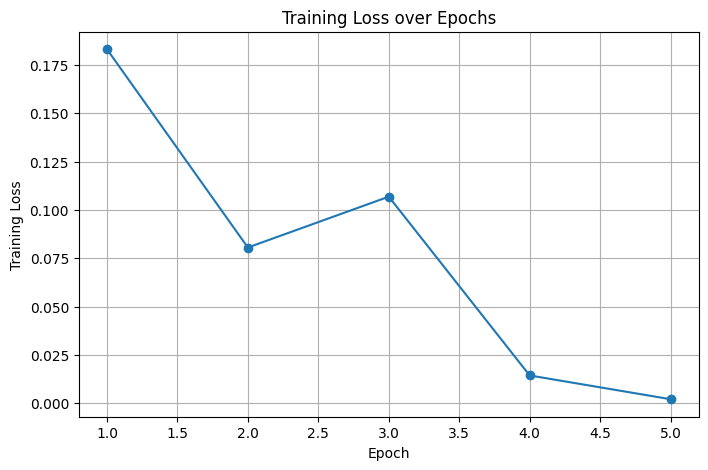

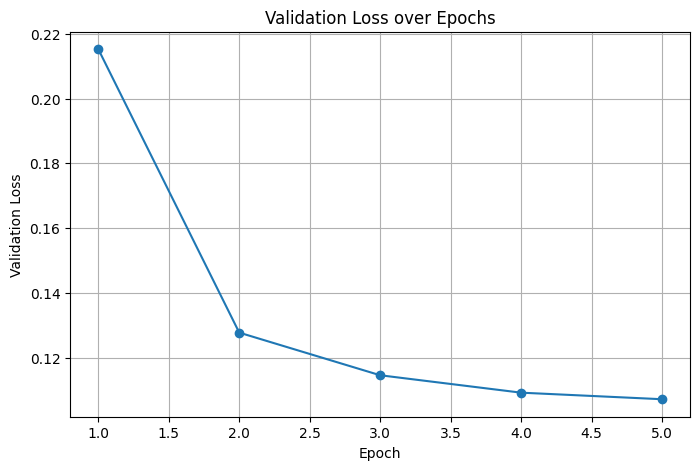

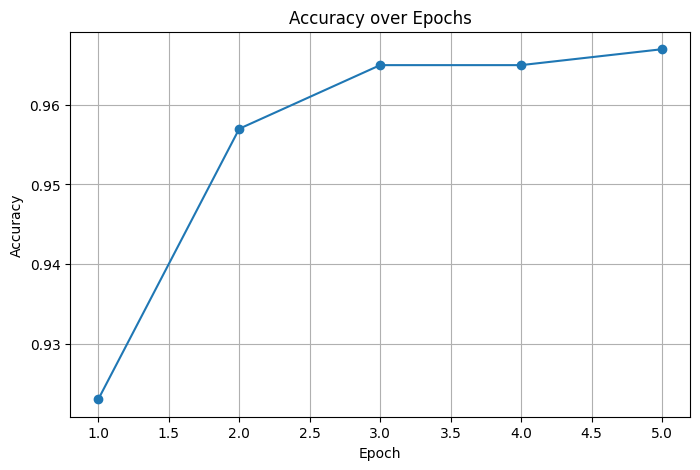

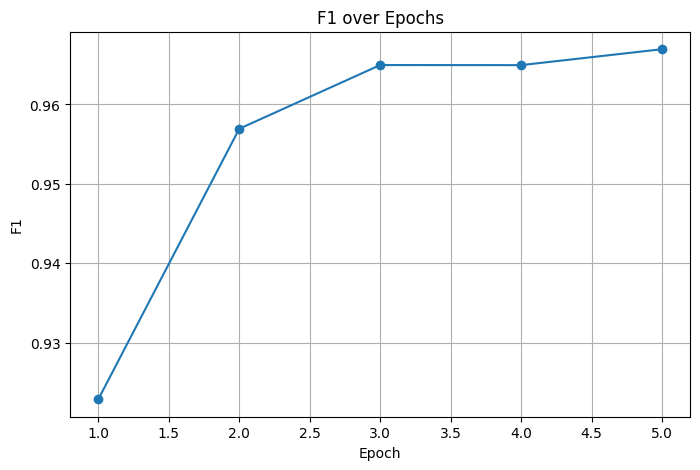

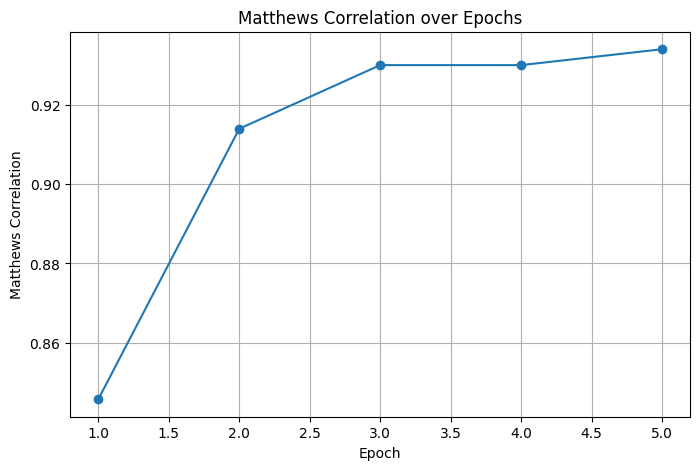

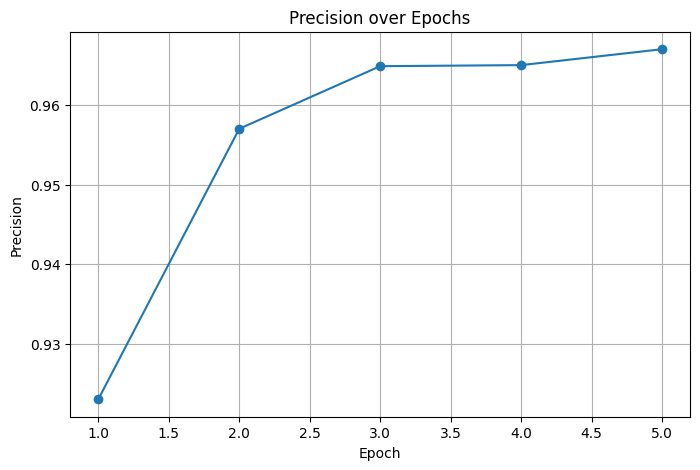

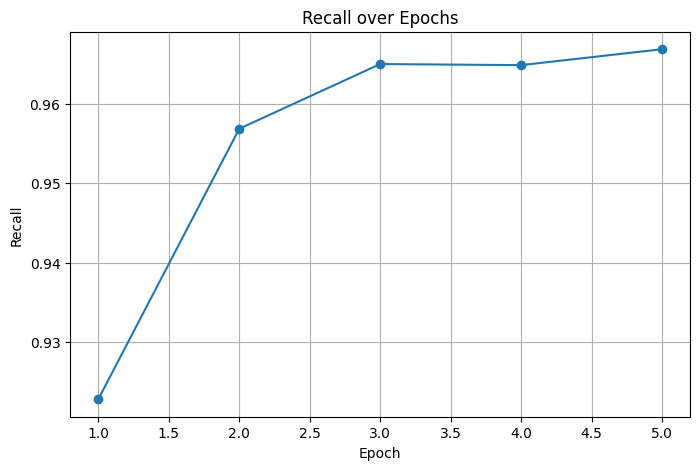

In [24]:
import matplotlib.pyplot as plt

progress = '''Epoch	Training Loss	Validation Loss	Accuracy	F1	Matthews Correlation	Precision	Recall
1	0.183200	0.215266	0.923000	0.922894	0.845806	0.922997	0.922809
2	0.080600	0.127715	0.957000	0.956941	0.913899	0.957051	0.956848
3	0.106900	0.114548	0.965000	0.964962	0.929926	0.964932	0.964994
4	0.014400	0.109169	0.965000	0.964952	0.929921	0.965064	0.964857
5	0.002100	0.107143	0.967000	0.966955	0.933927	0.967067	0.966860'''

lines = progress.strip().split('\n')
rows = lines[1:]
column_names = ['Epoch', 'Training Loss', 'Validation Loss', 'Accuracy', 'F1', 'Matthews Correlation', 'Precision', 'Recall']

df_progress = pd.read_csv(io.StringIO('\n'.join(rows)), sep='\s+', names=column_names, engine='python')

metrics_to_plot = ['Training Loss', 'Validation Loss', 'Accuracy', 'F1', 'Matthews Correlation', 'Precision', 'Recall']

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    # Use df_progress_new for both x and y axes
    plt.plot(df_progress['Epoch'], df_progress[metric], marker='o')
    plt.title(f'{metric} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.grid(True)
    plt.show()

In [58]:
def classify_protein_sequences(sequence):

  sequence = sequence.upper()
  print(sequence)

   # Check if there is input
  if not isinstance(sequence, str) or not sequence:
    return "Invalid input: Please provide a non-empty DNA sequence."

  # Check if length of input is valid
  if len(sequence) > tokenizer.model_max_length:
    return f'Input sequence is too long. Maximum length is {tokenizer.model_max_length}.'


  # Tokenize the input seq
  inputs = tokenizer(sequence, return_tensors='pt', padding=True, truncation=True)


  if 'token_type_ids' in inputs:
    del inputs['token_type_ids']


  # Make sure variables correspond to the device
  device = model.device
  inputs = {key: value.to(device) for key, value in inputs.items()}

  # Use the model to make a prediction
  with torch.no_grad():
    outputs = model(**inputs)

  # Get the output score from the model and use the highest class score
  logits = outputs.logits
  predicted_class_id = torch.argmax(logits, dim=1).item()

  #print(predicted_class_id)
  class_labels = ['nuclear', 'membrane']
  if predicted_class_id == 1:
    return class_labels[1]
  elif predicted_class_id == 0:
    return class_labels[0]
  else:
    return f'Unknown class ID: {predicted_class_id}'

In [ ]:
seq = ('MEMGRRIHLELRNRTPSDVKELVLDNSRSNEGKLEGLTDEFEELEFLSTIVGLTSIANLPKLNKLKKLELSDNRVSGGLEVLAEKCPNLTHLNLSGNKIKDLSTIEPLKKLENLKSLDLFNCEVTNLNDYRENVFKLLPQLTYLDGYDRDDKEAPDSDAEGYVEGLDDEEEDEDGG')
classify_protein_sequences(seq)

MEMGRRIHLELRNRTPSDVKELVLDNSRSNEGKLEGLTDEFEELEFLSTIVGLTSIANLPKLNKLKKLELSDNRVSGGLEVLAEKCPNLTHLNLSGNKIKDLSTIEPLKKLENLKSLDLFNCEVTNLNDYRENVFKLLPQLTYLDGYDRDDKEAPDSDAEGYVEGLDDEEEDEDGG


'nuclear'